### Analyze FVA for models under certain regression conditions

In [ ]:
import os.path as path
import glob, os
from datetime import datetime
from importlib.metadata import version
import cobra
import thermo_flux
from thermo_flux.io import load_excel as ex
from thermo_flux.io import helper_load as hl
from thermo_flux.core.model import ThermoModel
from thermo_flux.solver.gurobi import variability_analysis, variability_results, compute_IIS
from equilibrator_api import  Q_
import pandas as pd
import numpy as np
from scripts.logger import write_to_log
import gurobipy as gp
from gurobipy import GRB
from scripts.gen_model import gen_model
from scripts.gen_model import apply_physio_data
from scripts.gen_model import constrain_bounds_fva
from scripts.reaction_utils import list_and_remove_blocked_reactions
from scripts.reaction_utils import list_blocked_reactions
from scripts.reaction_utils import count_blocked_pathways
from scripts.reaction_utils import tfva_write_scenarios
from scripts.metabolite_utils import apply_met_tva

In [3]:
INPUT_MODEL = "datafiles/model.xlsx"
INPUT_KEGGS = "datafiles/ecoli_kegg_id.csv"
INPUT_REED = "regression/reed.csv"
INPUT_INCHI = "regression/InChIs.csv"
INPUT_GAMS = "regression/model_Ecoli_from-gams.xlsx"
INPUT_EXP_DATA = "regression/allPhysioData_formatted_forGSM_20230831.csv"
INPUT_EXP_CONC = "regression/allConcRange_20230912.csv"
INPUT_METABOLOMICS = "regression/metabolomics-Kochanowski_20230925.csv"

MODEL_NAME = "ecoli"

OUTPUT_DIR = "output"
OUTPUT_NAME = f"thermo_fva_test"
OUTPUT_LOG = f"{OUTPUT_DIR}{path.sep}{OUTPUT_NAME}_log.txt"

CONDITIONS_TO_REGRESS = ["WT-Glc_I"]

INCLUDE_CO2 = True
INCLUDE_O2 = True
ALLOW_OTHER_EXCRETION = True
RELAX_EXP_FLUX_BOUNDS = 2.0

time = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
write_to_log(OUTPUT_LOG, f"Started analysis at: {time}", "w")

# Write package versions:
modules = ["pandas", "numpy", "equilibrator_api", "cobra"]
write_to_log(OUTPUT_LOG, f"Package versions used:")
versions_packages = [f"  {m}: {version(m)}\n" for m in modules]
write_to_log(OUTPUT_LOG, "".join(versions_packages))

In [3]:
def setup_tfva_reaction(tmodel, var):
    m = tmodel.m

    # Reset objective
    for v in m.getVars():
        v.Obj = 0

    # Reset scenarios completely
    m.NumScenarios = 2
    m.update()

    # Clear scenario objectives
    for i in range(2):
        m.params.ScenarioNumber = i
        for v in m.getVars():
            v.ScenNObj = 0

    # Scenario 0 = minimize
    m.params.ScenarioNumber = 0
    var.ScenNObj = -1

    # Scenario 1 = maximize
    m.params.ScenarioNumber = 1
    var.ScenNObj = 1

    m.update()
    return m

In [ ]:
def run_tfva(tmodel, rxn): 
    SCENARIOS = [ GRB.MINIMIZE, GRB.MAXIMIZE ]
    for i in SCENARIOS:
        tmodel.m = None
        tmodel.m.Params.LogToConsole = 1
        tmodel.m.Params.OutputFlag = 1
        tmodel.objective = tmodel.reactions.get_by_id(rxn)
        tmodel.add_TFBA_variables()

        tmodel.m.setObjective(tmodel.m.getObjective(), i)
        tmodel.m.update()

        tmodel.m.Params.TimeLimit = 5
        tmodel.m.Params.Threads = 8
        tmodel.m.optimize()


In [ ]:
from scripts.reaction_utils import tfva_write_scenarios_one_model
REMOVE_BLOCKED = True
ALLOW_OTHER_EXCRETION = False
for c in CONDITIONS_TO_REGRESS:
    tmodel = gen_model(MODEL_NAME, INPUT_MODEL, INPUT_KEGGS, INPUT_REED, INPUT_INCHI, INPUT_GAMS, OUTPUT_LOG, True, True)
    tmodel = apply_physio_data(tmodel, c, INPUT_EXP_DATA, INPUT_EXP_CONC, INPUT_METABOLOMICS, INPUT_GAMS, RELAX_EXP_FLUX_BOUNDS, INCLUDE_CO2, INCLUDE_O2, ALLOW_OTHER_EXCRETION, OUTPUT_LOG)
    tfva_write_scenarios_one_model(tmodel, c, "tfva/Met_Applied", OUTPUT_LOG, lnc_unit="M", reactions_list=None, REMOVE_BLOCKED=REMOVE_BLOCKED, APPLY_FVA=True)
    #tfva_write_scenarios(tmodel, c, "tfva/Blocked_Removed", OUTPUT_LOG, lnc_unit="mM", num_reactions=5, REMOVE_BLOCKED=REMOVE_BLOCKED)


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2731723
Set parameter GURO_PAR_DUMP to value 1
Read parameters from file gurobi.env
Academic license 2731723 - for non-commercial use only - registered to l.___@student.rug.nl
['Parameters', 'Exchange reactions', 'Reactions', 'Biomass Composition', 'Transmembrane reactions', 'Metabolites', 'references', 'Transmembrane_reactions_reed', 'Transmembrane reactions_Orth', 'Transmembrane reactions old', 'Sheet3', 'log', 'subsystems']
*** Reading data from Reactions ***
unknown metabolite '2dhglcn[c]' created
unknown metabolite 'nadh[c]' created
unknown metabolite 'glcn[c]' created
unknown metabolite 'nad[c]' created
unknown metabolite 'nadph[c]' created
unknown metabolite 'nadp[c]' created
unknown metabolite '2dhguln[c]' created
unknown metabolite 'idon-L[c]' created
unknown metabolite '3hcinnm[c]' created
unknown metabolite 'o2[c]' created
unknown metabolite 'dhcinnm[c]' created
unknown metabolite 'h2o[c]' cre

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


for_e NOTHING DONE!
fru_e NOTHING DONE!
fuc1p-L_e NOTHING DONE!
fuc-L_e NOTHING DONE!
fum_e NOTHING DONE!
g6p_e NOTHING DONE!
gal_e NOTHING DONE!
galct-D_e NOTHING DONE!
galctn-D_e NOTHING DONE!
galt_e NOTHING DONE!
galur_e NOTHING DONE!
gam_e NOTHING DONE!
gbbtn_e NOTHING DONE!
glcn_e NOTHING DONE!
glcr_e NOTHING DONE!
glcur_e NOTHING DONE!
gln-L_e NOTHING DONE!
glu-L_e NOTHING DONE!
gly_e NOTHING DONE!
glyald_e NOTHING DONE!
glyb_e NOTHING DONE!
glyc_e NOTHING DONE!
glyc3p_e NOTHING DONE!
glyclt_e NOTHING DONE!
gsn_e NOTHING DONE!
gua_e NOTHING DONE!
h_e NOTHING DONE!
hdca_e NOTHING DONE!
his-L_e NOTHING DONE!
hxan_e NOTHING DONE!
idon-L_e NOTHING DONE!
ile-L_e NOTHING DONE!
indole_e NOTHING DONE!
ins_e NOTHING DONE!
k_e NOTHING DONE!
lac-D_e NOTHING DONE!
lac-L_e NOTHING DONE!
lcts_e NOTHING DONE!
leu-L_e NOTHING DONE!
lys-L_e NOTHING DONE!
mal-L_e NOTHING DONE!
malt_e NOTHING DONE!
malthx_e NOTHING DONE!
maltpt_e NOTHING DONE!
malttr_e NOTHING DONE!
maltttr_e NOTHING DONE!
man_e NO

In [4]:
print(tmodel.metabolites[0].lower_bound)

1.0000000002244704e-07 millimolar


Set parameter Username
Academic license - for non-commercial use only - expires 2026-11-02
['Parameters', 'Exchange reactions', 'Reactions', 'Biomass Composition', 'Transmembrane reactions', 'Metabolites', 'references', 'Transmembrane_reactions_reed', 'Transmembrane reactions_Orth', 'Transmembrane reactions old', 'Sheet3', 'log', 'subsystems']
*** Reading data from Reactions ***
unknown metabolite '2dhglcn[c]' created
unknown metabolite 'nadh[c]' created
unknown metabolite 'glcn[c]' created
unknown metabolite 'nad[c]' created
unknown metabolite 'nadph[c]' created
unknown metabolite 'nadp[c]' created
unknown metabolite '2dhguln[c]' created
unknown metabolite 'idon-L[c]' created
unknown metabolite '3hcinnm[c]' created
unknown metabolite 'o2[c]' created
unknown metabolite 'dhcinnm[c]' created
unknown metabolite 'h2o[c]' created
unknown metabolite '3hpppn[c]' created
unknown metabolite 'dhpppn[c]' created
unknown metabolite 'phthr[c]' created
unknown metabolite '4hthr[c]' created
unknown m

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


*** Updating metabolite information ***
2dhglcn_c NOTHING DONE!
nadh_c NOTHING DONE!
glcn_c NOTHING DONE!
nad_c NOTHING DONE!
nadph_c NOTHING DONE!
nadp_c NOTHING DONE!
2dhguln_c NOTHING DONE!
idon-L_c NOTHING DONE!
3hcinnm_c NOTHING DONE!
o2_c NOTHING DONE!
dhcinnm_c NOTHING DONE!
h2o_c NOTHING DONE!
3hpppn_c NOTHING DONE!
dhpppn_c NOTHING DONE!
phthr_c NOTHING DONE!
4hthr_c NOTHING DONE!
pi_c NOTHING DONE!
5dglcn_c NOTHING DONE!
ru5p-D_c NOTHING DONE!
ara5p_c NOTHING DONE!
ACP_c NOTHING DONE!
atp_c NOTHING DONE!
ttdca_c NOTHING DONE!
amp_c NOTHING DONE!
myrsACP_c NOTHING DONE!
ppi_c NOTHING DONE!
ttdcea_c NOTHING DONE!
tdeACP_c NOTHING DONE!
hdca_c NOTHING DONE!
palmACP_c NOTHING DONE!
hdcea_c NOTHING DONE!
hdeACP_c NOTHING DONE!
ocdcea_c NOTHING DONE!
octeACP_c NOTHING DONE!
dtdp4aaddg_c NOTHING DONE!
unagamu_c NOTHING DONE!
dtdp_c NOTHING DONE!
unagamuf_c NOTHING DONE!
arbt6p_c NOTHING DONE!
g6p_c NOTHING DONE!
hqn_c NOTHING DONE!
4abut_c NOTHING DONE!
akg_c NOTHING DONE!
glu-L_c N



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



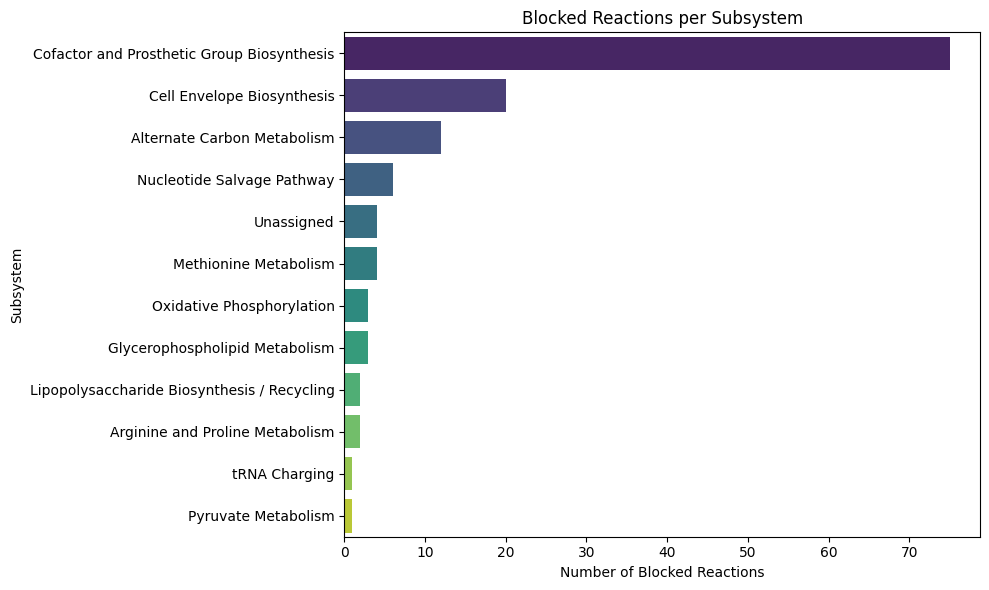

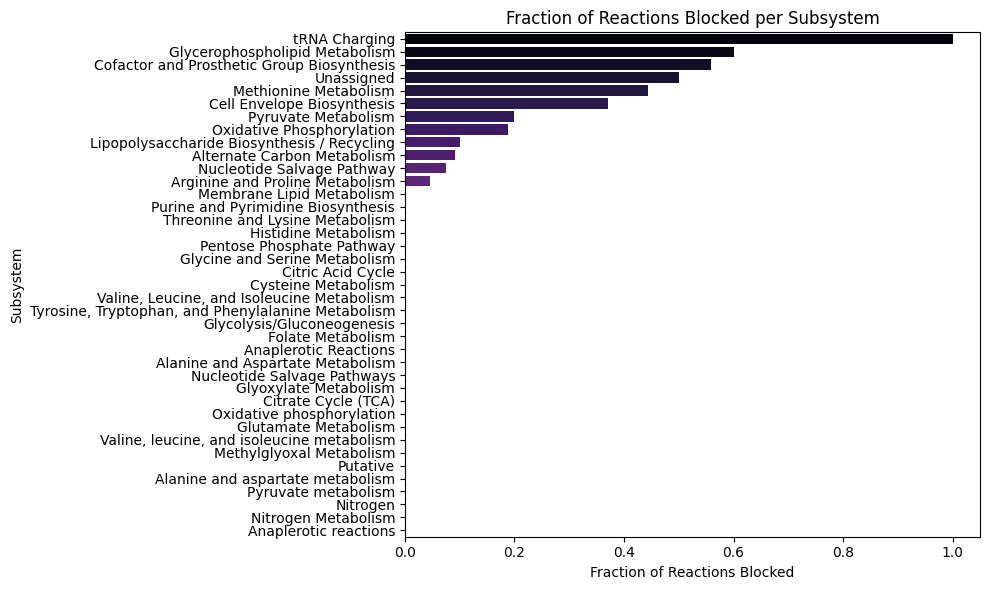

In [3]:
for c in CONDITIONS_TO_REGRESS:
    tmodel_p = gen_model(MODEL_NAME, INPUT_MODEL, INPUT_KEGGS, INPUT_REED, INPUT_INCHI, INPUT_GAMS, OUTPUT_LOG, True, True)
    tmodel_p = apply_physio_data(tmodel_p, c, INPUT_EXP_DATA, INPUT_EXP_CONC, INPUT_METABOLOMICS, INPUT_GAMS, RELAX_EXP_FLUX_BOUNDS, INCLUDE_CO2, INCLUDE_O2, ALLOW_OTHER_EXCRETION, OUTPUT_LOG)
    blocked_p = list_blocked_reactions(tmodel_p, c, OUTPUT_LOG, processes=1, open_exch=False)
    count_blocked_pathways(blocked_p, "ecoli", c, INPUT_MODEL)

In [ ]:
tmodel_p = gen_model(MODEL_NAME, INPUT_MODEL, INPUT_KEGGS, INPUT_REED, INPUT_INCHI, INPUT_GAMS, OUTPUT_LOG, True, True)
tmodel_p = apply_physio_data(tmodel_p, CONDITIONS_TO_REGRESS[0], INPUT_EXP_DATA, INPUT_EXP_CONC, INPUT_METABOLOMICS, INPUT_GAMS, RELAX_EXP_FLUX_BOUNDS, INCLUDE_CO2, INCLUDE_O2, ALLOW_OTHER_EXCRETION, OUTPUT_LOG)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-11-02
['Parameters', 'Exchange reactions', 'Reactions', 'Biomass Composition', 'Transmembrane reactions', 'Metabolites', 'references', 'Transmembrane_reactions_reed', 'Transmembrane reactions_Orth', 'Transmembrane reactions old', 'Sheet3', 'log', 'subsystems']
*** Reading data from Reactions ***
unknown metabolite '2dhglcn[c]' created
unknown metabolite 'nadh[c]' created
unknown metabolite 'glcn[c]' created
unknown metabolite 'nad[c]' created
unknown metabolite 'nadph[c]' created
unknown metabolite 'nadp[c]' created
unknown metabolite '2dhguln[c]' created
unknown metabolite 'idon-L[c]' created
unknown metabolite '3hcinnm[c]' created
unknown metabolite 'o2[c]' created
unknown metabolite 'dhcinnm[c]' created
unknown metabolite 'h2o[c]' created
unknown metabolite '3hpppn[c]' created
unknown metabolite 'dhpppn[c]' created
unknown metabolite 'phthr[c]' created
unknown metabolite '4hthr[c]' created
unknown m

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


*** Updating metabolite information ***
2dhglcn_c NOTHING DONE!
nadh_c NOTHING DONE!
glcn_c NOTHING DONE!
nad_c NOTHING DONE!
nadph_c NOTHING DONE!
nadp_c NOTHING DONE!
2dhguln_c NOTHING DONE!
idon-L_c NOTHING DONE!
3hcinnm_c NOTHING DONE!
o2_c NOTHING DONE!
dhcinnm_c NOTHING DONE!
h2o_c NOTHING DONE!
3hpppn_c NOTHING DONE!
dhpppn_c NOTHING DONE!
phthr_c NOTHING DONE!
4hthr_c NOTHING DONE!
pi_c NOTHING DONE!
5dglcn_c NOTHING DONE!
ru5p-D_c NOTHING DONE!
ara5p_c NOTHING DONE!
ACP_c NOTHING DONE!
atp_c NOTHING DONE!
ttdca_c NOTHING DONE!
amp_c NOTHING DONE!
myrsACP_c NOTHING DONE!
ppi_c NOTHING DONE!
ttdcea_c NOTHING DONE!
tdeACP_c NOTHING DONE!
hdca_c NOTHING DONE!
palmACP_c NOTHING DONE!
hdcea_c NOTHING DONE!
hdeACP_c NOTHING DONE!
ocdcea_c NOTHING DONE!
octeACP_c NOTHING DONE!
dtdp4aaddg_c NOTHING DONE!
unagamu_c NOTHING DONE!
dtdp_c NOTHING DONE!
unagamuf_c NOTHING DONE!
arbt6p_c NOTHING DONE!
g6p_c NOTHING DONE!
hqn_c NOTHING DONE!
4abut_c NOTHING DONE!
akg_c NOTHING DONE!
glu-L_c N

NameError: name 'c' is not defined

In [5]:
tmodel_p = apply_physio_data(tmodel_p, CONDITIONS_TO_REGRESS[0], INPUT_EXP_DATA, INPUT_EXP_CONC, INPUT_METABOLOMICS, INPUT_GAMS, RELAX_EXP_FLUX_BOUNDS, INCLUDE_CO2, INCLUDE_O2, ALLOW_OTHER_EXCRETION, OUTPUT_LOG)

['EX_12ppd-S', 'EX_15dap', 'EX_26dap-M', 'EX_2ddglcn', 'EX_3hcinnm', 'EX_3hpppn', 'EX_4abut', 'EX_ac', 'EX_acac', 'EX_acald', 'EX_acgam', 'EX_acmana', 'EX_acnam', 'EX_ade', 'EX_adn', 'EX_akg', 'EX_ala-D', 'EX_ala-L', 'EX_alltn', 'EX_amp', 'EX_arab-L', 'EX_arg-L', 'EX_asn-L', 'EX_asp-L', 'EX_but', 'EX_C', 'EX_cbl1', 'EX_chol', 'EX_cit', 'EX_co2', 'EX_crn', 'EX_csn', 'EX_cynt', 'EX_cys-L', 'EX_cytd', 'EX_dad-2', 'EX_dcyt', 'EX_dgsn', 'EX_dha', 'EX_din', 'EX_dms', 'EX_dmso', 'EX_duri', 'EX_etoh', 'EX_fe2', 'EX_for', 'EX_fru', 'EX_fuc1p-L', 'EX_fuc-L', 'EX_fum', 'EX_g6p', 'EX_gal', 'EX_galct-D', 'EX_galctn-D', 'EX_galt', 'EX_galur', 'EX_gam', 'EX_gbbtn', 'EX_glc', 'EX_glcn', 'EX_glcr', 'EX_glcur', 'EX_gln-L', 'EX_glu-L', 'EX_gly', 'EX_glyald', 'EX_glyb', 'EX_glyc', 'EX_glyc3p', 'EX_glyclt', 'EX_gsn', 'EX_gua', 'EX_h', 'EX_h2o', 'EX_hdca', 'EX_his-L', 'EX_hxan', 'EX_idon-L', 'EX_ile-L', 'EX_indole', 'EX_ins', 'EX_k', 'EX_lac-D', 'EX_lac-L', 'EX_lcts', 'EX_leu-L', 'EX_lys-L', 'EX_mal-L', 'EX

In [6]:
print(tmodel_p.reactions.biomass)

biomass: 0.05 5mthf_c + 5e-05 accoa_c + 0.488 ala-L_c + 0.001 amp_c + 0.281 arg-L_c + 0.229 asn-L_c + 0.229 asp-L_c + 54.1352 atp_c + 0.000129 clpnEC_c + 6e-06 coa_c + 0.126 ctp_c + 0.087 cys-L_c + 0.0247 datp_c + 0.0254 dctp_c + 0.0254 dgtp_c + 0.0247 dttp_c + 1e-05 fad_c + 0.25 gln-L_c + 0.25 glu-L_c + 0.582 gly_c + 0.154 glycogen_c + 0.203 gtp_c + 53.95 h2o_c + 0.09 his-L_c + 0.276 ile-L_c + 0.428 leu-L_c + 0.0084 lpsEC_c + 0.326 lys-L_c + 0.146 met-L_c + 0.00215 nad_c + 5e-05 nadh_c + 0.00013 nadp_c + 0.0004 nadph_c + 0.001935 peEC_c + 0.0276 peptidoEC_c + 0.000464 pgEC_c + 0.176 phe-L_c + 0.21 pro-L_c + 5.2e-05 psEC_c + 0.035 ptrc_c + 0.205 ser-L_c + 0.007 spmd_c + 3e-06 succoa_c + 0.241 thr-L_c + 0.054 trp-L_c + 0.131 tyr-L_c + 0.003 udpg_c + 0.136 utp_c + 0.402 val-L_c <=> 53.95 adp_c + biomass_c + 60.321747969796235 h_c + 53.952 pi_c + 0.7302 ppi_c


In [8]:
print(tmodel_p.metabolites.glutrna_c.reactions)

frozenset({<ThermoReaction GLUTRS at 0x192af5da930>, <ThermoReaction GLUTRR at 0x192af5d9af0>})


In [9]:
print(tmodel_p.metabolites.trnaglu_c.reactions)

frozenset({<ThermoReaction GLUTRS at 0x192af5da930>, <ThermoReaction GLUTRR at 0x192af5d9af0>})


In [4]:
print(blocked_p)

['4HTHRS', 'AADDGT', 'AB6PGH', 'ACBIPGT', 'ACGAMT', 'ACMAMUT', 'ACONMT', 'ACPS1', 'ADK4', 'ADNCYC', 'ADOCBIK', 'ADOCBLS', 'AHC', 'AHCYSNS', 'ALDD19x', 'AMAOTr', 'AMMQT82', 'AMPMS', 'AOXSr', 'AP4AH', 'AP5AH', 'BTS2', 'CBIAT', 'CBLAT', 'CDPMEK', 'CINNDO', 'CPPPGO', 'CRNBTCT', 'CRNCBCT', 'CRNCDH', 'CYANST', 'DBTSr', 'DHBD', 'DHBSr', 'DHCIND', 'DHNAOT', 'DHPTDC', 'DMATT', 'DMQMT', 'DOGULNR', 'DXPRIi', 'DXPS', 'DXYLK', 'E4PD', 'ECAPEC', 'EDTXS3', 'EDTXS4', 'ENTCS', 'FCLT', 'FHL', 'G1PTT', 'G1SATi', 'GDMANE', 'glucys', 'GLUTRR', 'GLUTRS', 'GMAND', 'GOFUCR', 'GP4GH', 'GPDDA1', 'GPDDA3', 'GPDDA5', 'GRTT', 'GTHOr', 'GTHS', 'HBZOPT', 'HEMEOS', 'HETZK', 'HMBS', 'HMPK1', 'ICHORSi', 'ICHORT', 'KG6PDC', 'MAN1PT2', 'MECDPDH', 'MECDPS', 'MEPCT', 'MI1PP', 'NADDPe', 'NNDMBRT', 'NPHS', 'OCTDPS', 'OHPBAT', 'OHPHM', 'OMBZLM', 'OMMBLHX', 'OMPHHX', 'OPHBDC', 'OPHHX', 'OXGDC2', 'PACCOAL', 'PDX5PO', 'PDX5PS', 'PEAMNO', 'PERD', 'PGLYCP', 'PLIPA3', 'PMANM', 'PMPK', 'PPBNGS', 'PPPGO', 'RHCCE', 'RZ5PP', 'SELNPS', 

In [27]:
tmodel.m.Params.TimeLimit = 7200
constr, bound, infeas_rxn, infeas_mets = compute_IIS(tmodel)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


Computing Irreducible Inconsistent Subsystem (IIS)...

           Constraints          |            Bounds           |  Runtime
      Min       Max     Guess   |   Min       Max     Guess   |
--------------------------------------------------------------------------
        0      8914         -         0     11330         -           0s
        0      7726         -         0     10358         -          10s
        0      7726         -         0     10358         -          24s
        0      6954         -         0     10066         -          26s
        0      6259         -         0      9733         -          30s
        0      6259        10         0      9733         -          35s
        0      6259        10         0    

In [31]:
for x in constr:
    print(x)
for x in bound:
    print(bound)

drG_conc_constraint_[268]
drG_constraint_[268]
mass_balance_pos[124]
mass_balance_pos[126]
mass_balance_pos[274]
mass_balance_pos[275]
mass_balance_pos[285]
mass_balance_pos[371]
mass_balance_pos[476]
mass_balance_pos[484]
mass_balance_pos[770]
mass_balance_pos[771]
integer_rev_HPPK2_
drG_netHPPK2_
drG_pos_HPPK2_
drG_error_constraint[268]
<gurobi.GenConstr 0>
[<gurobi.Var fluxes[0,897]>, <gurobi.Var drG_negative[0,268]>, <gurobi.Var ln_conc[0,21]>, <gurobi.Var ln_conc[0,23]>, <gurobi.Var ln_conc[0,279]>, <gurobi.Var ln_conc[0,285]>, <gurobi.Var ln_conc[0,754]>, <gurobi.Var feasvar>, <gurobi.Var mnorm>]
[<gurobi.Var fluxes[0,897]>, <gurobi.Var drG_negative[0,268]>, <gurobi.Var ln_conc[0,21]>, <gurobi.Var ln_conc[0,23]>, <gurobi.Var ln_conc[0,279]>, <gurobi.Var ln_conc[0,285]>, <gurobi.Var ln_conc[0,754]>, <gurobi.Var feasvar>, <gurobi.Var mnorm>]
[<gurobi.Var fluxes[0,897]>, <gurobi.Var drG_negative[0,268]>, <gurobi.Var ln_conc[0,21]>, <gurobi.Var ln_conc[0,23]>, <gurobi.Var ln_conc[0,2

In [21]:
rxn_ids = [r.id for r in tmodel.reactions]
for rxn_id in rxn_ids[:5]:
    rxn = tmodel.reactions.get_by_id(rxn_id)
    idx = tmodel.reactions.index(rxn)    
    run_tfva(tmodel, rxn_id)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
Set parameter Threads to value 8
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 8 threads

Optimize a model with 8913 rows, 7475 columns and 240478 nonzeros
Model fingerprint: 0x036d802d
Model has 1 general constraint
Variable types: 6570 continuous, 905 integer (905 binary)
Coefficient statistics:
  Matrix range     [3e-06, 7e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e-01, 1e+06]
  RHS range        [4e-15, 1e+05]
Presolve removed 4747 rows and 3967 columns
Presolve time: 0.54s
Presolved: 4167 rows, 3869 columns, 196941 nonzeros
Presolved model has 361 quadratic constraint(s)
Variable types: 3202 continuous, 667 integer (667 binary)

Root relaxation: objective -1.000000e+02, 3779 iterations, 0.44 seconds (1.35

In [22]:
tmodel.m = None
tmodel.objective = tmodel.reactions.biomass_EX
tmodel.add_TFBA_variables()
tmodel.m.optimize()

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 8913 rows, 7475 columns and 240478 nonzeros
Model fingerprint: 0x9756020e
Model has 1 general constraint
Variable types: 6570 continuous, 905 integer (905 binary)
Coefficient statistics:
  Matrix range     [3e-06, 7e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e-01, 1e+06]
  RHS range        [4e-15, 1e+05]
Presolve removed 4747 rows and 3967 columns
Presolve time: 0.54s
Presolved: 4167 rows, 3869 columns, 196942 nonzeros
Presolved model has 361 quadratic constraint(s)
Variable types: 3202 continuous, 667 integer (667 binary)

Root relaxation: objective 7.018798e-01, 3098 iterations, 0.31 seconds (0.94 work units)

    Nodes    |    C

In [ ]:
tmodel.m = None
tmodel.objective = tmodel.reactions.get_by_id("2DGLCNRx")
tmodel.add_TFBA_variables()

tmodel.m.setObjective(tmodel.m.getObjective() * -1)
tmodel.m.update()

tmodel.m.Params.TimeLimit = 5
tmodel.m.optimize()

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 5
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 8913 rows, 7475 columns and 240478 nonzeros
Model fingerprint: 0x4e9ec83d
Model has 1 general constraint
Variable types: 6570 continuous, 905 integer (905 binary)
Coefficient statistics:
  Matrix range     [3e-06, 7e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e-01, 1e+06]
  RHS range        [4e-15, 1e+05]
Presolve removed 4747 rows and 3967 columns
Presolve time: 0.55s
Presolved: 4167 rows, 3869 columns, 196941 nonzeros
Presolved model has 361 quadratic constraint(s)
Variable types: 3202 continuous, 667 integer (667 binary)

Root relaxation: objective 1.000000e+02, 3779 iterations, 0.46 seconds (1.

In [ ]:
res = []
for c in CONDITIONS_TO_REGRESS:
    tmodel = gen_model(MODEL_NAME, INPUT_MODEL, INPUT_KEGGS, INPUT_REED, INPUT_INCHI, INPUT_GAMS, OUTPUT_LOG, True, True)
    tmodel = apply_physio_data(tmodel, c, INPUT_EXP_DATA, INPUT_EXP_CONC, INPUT_METABOLOMICS, INPUT_GAMS, RELAX_EXP_FLUX_BOUNDS, INCLUDE_CO2, INCLUDE_O2, ALLOW_OTHER_EXCRETION, OUTPUT_LOG)

    tmodel.m = None  
    tmodel.objective = tmodel.reactions.biomass_EX  
    tmodel.add_TFBA_variables() 
    
    rxn_ids = [r.id for r in tmodel.reactions]
    for rxn_id in rxn_ids:
        rxn = tmodel.reactions.get_by_id(rxn_id)
        idx = tmodel.reactions.index(rxn)

        v_var = [ tmodel.mvars["v"][0][idx] ]
        print(v_var[0])

        gm = None
        gm = variability_analysis(tmodel, v_var)
        gm.Params.TimeLimit = 3600
        gm.Params.Threads = 16
        gm.optimize()

        gm.write(f"solutions/TFVA/{c}_{rxn_id}_{idx}.sol")
        tmodel.m = gm

        opt_bounds, obj_val, obj_bound, gaps = variability_results(tmodel)

        res.append([opt_bounds, obj_val, obj_bound, gaps])
        
        #gm.write(f"tfva{path.sep}{c}{path.sep}{rxn_id}_{idx}_tfva.mps.gz")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-11-02
['Parameters', 'Exchange reactions', 'Reactions', 'Biomass Composition', 'Transmembrane reactions', 'Metabolites', 'references', 'Transmembrane_reactions_reed', 'Transmembrane reactions_Orth', 'Transmembrane reactions old', 'Sheet3', 'log', 'subsystems']
*** Reading data from Reactions ***
unknown metabolite '2dhglcn[c]' created
unknown metabolite 'nadh[c]' created
unknown metabolite 'glcn[c]' created
unknown metabolite 'nad[c]' created
unknown metabolite 'nadph[c]' created
unknown metabolite 'nadp[c]' created
unknown metabolite '2dhguln[c]' created
unknown metabolite 'idon-L[c]' created
unknown metabolite '3hcinnm[c]' created
unknown metabolite 'o2[c]' created
unknown metabolite 'dhcinnm[c]' created
unknown metabolite 'h2o[c]' created
unknown metabolite '3hpppn[c]' created
unknown metabolite 'dhpppn[c]' created
unknown metabolite 'phthr[c]' created
unknown metabolite '4hthr[c]' created
unknown m

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


*** Updating metabolite information ***
2dhglcn_c NOTHING DONE!
nadh_c NOTHING DONE!
glcn_c NOTHING DONE!
nad_c NOTHING DONE!
nadph_c NOTHING DONE!
nadp_c NOTHING DONE!
2dhguln_c NOTHING DONE!
idon-L_c NOTHING DONE!
3hcinnm_c NOTHING DONE!
o2_c NOTHING DONE!
dhcinnm_c NOTHING DONE!
h2o_c NOTHING DONE!
3hpppn_c NOTHING DONE!
dhpppn_c NOTHING DONE!
phthr_c NOTHING DONE!
4hthr_c NOTHING DONE!
pi_c NOTHING DONE!
5dglcn_c NOTHING DONE!
ru5p-D_c NOTHING DONE!
ara5p_c NOTHING DONE!
ACP_c NOTHING DONE!
atp_c NOTHING DONE!
ttdca_c NOTHING DONE!
amp_c NOTHING DONE!
myrsACP_c NOTHING DONE!
ppi_c NOTHING DONE!
ttdcea_c NOTHING DONE!
tdeACP_c NOTHING DONE!
hdca_c NOTHING DONE!
palmACP_c NOTHING DONE!
hdcea_c NOTHING DONE!
hdeACP_c NOTHING DONE!
ocdcea_c NOTHING DONE!
octeACP_c NOTHING DONE!
dtdp4aaddg_c NOTHING DONE!
unagamu_c NOTHING DONE!
dtdp_c NOTHING DONE!
unagamuf_c NOTHING DONE!
arbt6p_c NOTHING DONE!
g6p_c NOTHING DONE!
hqn_c NOTHING DONE!
4abut_c NOTHING DONE!
akg_c NOTHING DONE!
glu-L_c N

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "c:\Users\iLawz\.conda\envs\thermo\Lib\site-packages\IPython\core\interactiveshell.py", line 3043, in write
    def write(data, *args, **kwargs):

KeyboardInterrupt: 


In [13]:
def tfva_run_scenarios_mets(tmodel, condition, output_folder, OUTPUT_LOG, lnc_unit="M", num_reactions=-1, REMOVE_BLOCKED=True, APPLY_FVA=True):
    "Writes TFVA scenario files to the specified output folder, 1 file for each reaction"
    blocked_p = list_blocked_reactions(tmodel, condition, OUTPUT_LOG, 1, False)
    print(len(blocked_p))

    if REMOVE_BLOCKED:
        tmodel.remove_reactions(blocked_p, remove_orphans=True)

        if APPLY_FVA:

            print("Bounds before FVA: ")
            for x in tmodel.reactions:
                print(f"{x.lower_bound}, {x.upper_bound}")

            constrain_bounds_fva(tmodel, OUTPUT_LOG)

            print("Bounds after FVA: ")
            for x in tmodel.reactions:
                print(f"{x.lower_bound}, {x.upper_bound}")

        for rxn in tmodel.reactions:
            thermo_flux.tools.drg_tools.reaction_balance(rxn, balance_charge=True, balance_mg=False)
        tmodel.update_thermo_info(fit_unknown_dfG0=True)
    else:
        for rxn in blocked_p:
            tmodel.reactions.get_by_id(rxn).lower_bound = 0
            tmodel.reactions.get_by_id(rxn).upper_bound = 0

    tmodel.m = None  
    tmodel.objective = tmodel.reactions.biomass_EX  
    tmodel.add_TFBA_variables(lnc_unit=lnc_unit)

    tmodel.m.Params.TimeLimit = 20
    tmodel.m.optimize()

    vars = []
    for i, met in enumerate(tmodel.metabolites):
        v = tmodel.mvars["ln_conc"][0][i]
        vars.append(v)
        print(f"Added {met.id} : { v }")

    gm = variability_analysis(tmodel, vars)
    #gm.Params.TimeLimit = 3600
    #gm.Params.Threads = 8
    #gm.optimize()
    gm.write("WT-Glc_I_TFVA_Conc.mps.gz")

In [15]:
tmodel = gen_model(MODEL_NAME, INPUT_MODEL, INPUT_KEGGS, INPUT_REED, INPUT_INCHI, INPUT_GAMS, OUTPUT_LOG, True, True)
tmodel = apply_physio_data(tmodel, CONDITIONS_TO_REGRESS[0], INPUT_EXP_DATA, INPUT_EXP_CONC, INPUT_METABOLOMICS, INPUT_GAMS, RELAX_EXP_FLUX_BOUNDS, INCLUDE_CO2, INCLUDE_O2, False, OUTPUT_LOG)

['Parameters', 'Exchange reactions', 'Reactions', 'Biomass Composition', 'Transmembrane reactions', 'Metabolites', 'references', 'Transmembrane_reactions_reed', 'Transmembrane reactions_Orth', 'Transmembrane reactions old', 'Sheet3', 'log', 'subsystems']
*** Reading data from Reactions ***
unknown metabolite '2dhglcn[c]' created
unknown metabolite 'nadh[c]' created
unknown metabolite 'glcn[c]' created
unknown metabolite 'nad[c]' created
unknown metabolite 'nadph[c]' created
unknown metabolite 'nadp[c]' created
unknown metabolite '2dhguln[c]' created
unknown metabolite 'idon-L[c]' created
unknown metabolite '3hcinnm[c]' created
unknown metabolite 'o2[c]' created
unknown metabolite 'dhcinnm[c]' created
unknown metabolite 'h2o[c]' created
unknown metabolite '3hpppn[c]' created
unknown metabolite 'dhpppn[c]' created
unknown metabolite 'phthr[c]' created
unknown metabolite '4hthr[c]' created
unknown metabolite 'pi[c]' created
unknown metabolite '5dglcn[c]' created
unknown metabolite 'ru5p-D

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


gam_e NOTHING DONE!
gbbtn_e NOTHING DONE!
glcn_e NOTHING DONE!
glcr_e NOTHING DONE!
glcur_e NOTHING DONE!
gln-L_e NOTHING DONE!
glu-L_e NOTHING DONE!
gly_e NOTHING DONE!
glyald_e NOTHING DONE!
glyb_e NOTHING DONE!
glyc_e NOTHING DONE!
glyc3p_e NOTHING DONE!
glyclt_e NOTHING DONE!
gsn_e NOTHING DONE!
gua_e NOTHING DONE!
h_e NOTHING DONE!
hdca_e NOTHING DONE!
his-L_e NOTHING DONE!
hxan_e NOTHING DONE!
idon-L_e NOTHING DONE!
ile-L_e NOTHING DONE!
indole_e NOTHING DONE!
ins_e NOTHING DONE!
k_e NOTHING DONE!
lac-D_e NOTHING DONE!
lac-L_e NOTHING DONE!
lcts_e NOTHING DONE!
leu-L_e NOTHING DONE!
lys-L_e NOTHING DONE!
mal-L_e NOTHING DONE!
malt_e NOTHING DONE!
malthx_e NOTHING DONE!
maltpt_e NOTHING DONE!
malttr_e NOTHING DONE!
maltttr_e NOTHING DONE!
man_e NOTHING DONE!
man6p_e NOTHING DONE!
melib_e NOTHING DONE!
met-D_e NOTHING DONE!
met-L_e NOTHING DONE!
mnl_e NOTHING DONE!
na1_e NOTHING DONE!
nac_e NOTHING DONE!
nh3_e NOTHING DONE!
no2_e NOTHING DONE!
no3_e NOTHING DONE!
o2_e NOTHING DONE!

In [16]:
from scripts.metabolite_utils import remove_orphan_metabolites
blocked_p = list_blocked_reactions(tmodel, CONDITIONS_TO_REGRESS[0], OUTPUT_LOG, 1, False)
print(len(blocked_p))

tmodel.remove_reactions(blocked_p, remove_orphans=True)
remove_orphan_metabolites(tmodel)
for rxn in tmodel.reactions:
    thermo_flux.tools.drg_tools.reaction_balance(rxn, balance_charge=True, balance_mg=False)
tmodel.update_thermo_info(fit_unknown_dfG0=True)

['3HCINNMH', '3HPPPNH', '4HTHRS', '5DGLCNR', 'AADDGT', 'AB6PGH', 'ACACCT', 'ACACT1r', 'ACBIPGT', 'ACGAMT', 'ACMAMUT', 'ACNML', 'ACONMT', 'ACPS1', 'ADHEr', 'ADK4', 'ADNCYC', 'ADOCBIK', 'ADOCBLS', 'AGDC', 'AGMT', 'AHC', 'AHCYSNS', 'ALCD19', 'ALDD19x', 'ALLTAH', 'alltn', 'ALTRH', 'AMANAPE', 'AMANK', 'AMAOTr', 'AMMQT82', 'AMPMS', 'AOXSr', 'AP4AH', 'AP5AH', 'ARAI', 'ARGDC', 'BTS2', 'BUTCT', 'CBIAT', 'CBLAT', 'CDPMEK', 'CHRPL', 'CINNDO', 'CPPPGO', 'CRNBTCT', 'CRNCBCT', 'CRNCDH', 'CYANST', 'CYNTAH', 'DBTSr', 'DDGALK', 'DDGLK', 'DDPGALA', 'DHBD', 'DHBSr', 'DHCIND', 'DHCINDO', 'DHNAOT', 'DHPPD', 'DHPTDC', 'DMATT', 'DMQMT', 'DOGULNR', 'DXPRIi', 'DXPS', 'DXYLK', 'E4PD', 'ECAPEC', 'EDTXS3', 'EDTXS4', 'ENTCS', 'FAO3', 'FAO4', 'FCI', 'FCLK', 'FCLPA', 'FCLT', 'FFSD', 'FHL', 'G1PTT', 'G1SATi', 'GALCTD', 'GALCTND', 'GALKr', 'GALS3', 'GDMANE', 'GLCRAL', 'GLCRD', 'GLTPD', 'glucys', 'GLUTRR', 'GLUTRS', 'GMAND', 'GOFUCR', 'GP4GH', 'GPDDA1', 'GPDDA3', 'GPDDA5', 'GRTT', 'GTHOr', 'GTHS', 'GUI1', 'GUI2', 'HBZO

In [12]:
tfva_run_scenarios_mets(tmodel, "WT-Glc_I", "", OUTPUT_LOG, lnc_unit="M", num_reactions=-1, REMOVE_BLOCKED=True, APPLY_FVA=True)

[]
0
0
Bounds before FVA: 
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
3.15, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-10

In [17]:
tfva_run_scenarios_mets(tmodel, "WT-Glc_I", "", OUTPUT_LOG, lnc_unit="M", num_reactions=-1, REMOVE_BLOCKED=True, APPLY_FVA=True)

[]
0
0
Bounds before FVA: 
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
3.15, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-100, 100
-10